In [2]:
import sys
import types
import pandas as pd
from ibm_botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
#Importing data and relavent code libraries.


In [ ]:
#Personal Keys Removed

In [4]:
client_cred.download_file(Bucket=bucket,Key='df_heating_cos.pkl',Filename='./df_heating_local.pkl')
client_cred.download_file(Bucket=bucket,Key='df_pluto_cos.pkl',Filename='./df_pluto_local.pkl')


In [5]:
df_heating = pd.read_pickle('./df_heating_local.pkl')
df_pluto = pd.read_pickle('./df_pluto_local.pkl')

In [7]:
df_heating.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
2,2020-02-05 20:44:10,45554755,HEAT/HOT WATER,11216.0,815 PARK PLACE,PARK PLACE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.673471,-73.950921,NaN,RESIDENTIAL BUILDING,Open
3,2020-02-05 07:47:17,45553828,HEAT/HOT WATER,10003.0,332 EAST 9 STREET,EAST 9 STREET,ADDRESS,NEW YORK,The Department of Housing Preservation and Dev...,MANHATTAN,40.728796,-73.986351,2020-02-05T17:25:20.000,RESIDENTIAL BUILDING,Closed
4,2020-02-05 18:48:25,45553886,HEAT/HOT WATER,10034.0,125 VERMILYEA AVENUE,VERMILYEA AVENUE,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.866492,-73.921313,NaN,RESIDENTIAL BUILDING,Open
6,2020-02-05 11:48:08,45554777,HEAT/HOT WATER,10040.0,16 BROADWAY TERRACE,BROADWAY TERRACE,ADDRESS,NEW YORK,The Department of Housing Preservation and Dev...,MANHATTAN,40.857131,-73.931319,2020-02-05T21:29:02.000,RESIDENTIAL BUILDING,Closed
10,2020-02-05 12:31:08,45555765,HEAT/HOT WATER,11230.0,2010 OCEAN AVENUE,OCEAN AVENUE,ADDRESS,BROOKLYN,The complaint you filed is a duplicate of a co...,BROOKLYN,40.612692,-73.953941,NaN,RESIDENTIAL BUILDING,Open


In [8]:
df_pluto.head()

,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
1,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,0.0,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
2,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,1.0,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
3,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,2.0,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
4,17,10454.0,144 BRUCKNER BOULEVARD,2500,10625,0,0,2125,1,5.0,100.0,85.0,1931,2001,4.25,6.02,5.0,6.5,1006299.0,232033.0
5,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,5.0,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


In [9]:
#Creating a mask to seperate data into only bronx, to reduce overall computation time, then counted and segregated number of incidents at each adress ready to merge into pluto dataset
mask=(df_heating['borough']=='BRONX')
df_heating_bronx=df_heating.loc[mask]
df_heating_bronx['borough']
df_tomerge=pd.DataFrame(df_heating_bronx['incident_address'].value_counts().reset_index().values,columns=["Address", "incident count"])

In [10]:
df_merged=pd.merge(df_pluto,df_tomerge, on="Address")

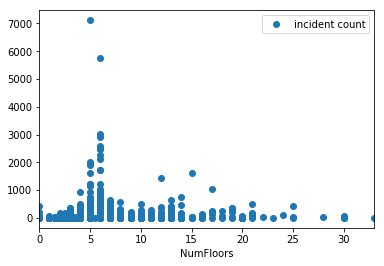

In [11]:
#Randomly selected numfloors as a quick test to see how correlated some of the variables may be visually. From a quick glance it would seem that there is a reasonable correlation between having 5 floors and having many of the complaints
df_merged.plot(x='NumFloors',y='incident count',style='o')

In [12]:
#Calculating pearson values for each statistic to get a better idea of what is actually correlating
pearsonvals=[]
rval=[]
for col in df_merged.columns:
    try:
        pearsonvals.append(stats.pearsonr(df_merged[col],df_merged['incident count'])[0])
    except TypeError:
        pearsonvals.append(0)
pearsonvalsdf=pd.DataFrame()
pearsonvalsdf['Columns']=df_merged.columns
pearsonvalsdf['Pearson Value']=pearsonvals
pearsonvalsdf.set_index("Columns",drop=True,inplace=True)

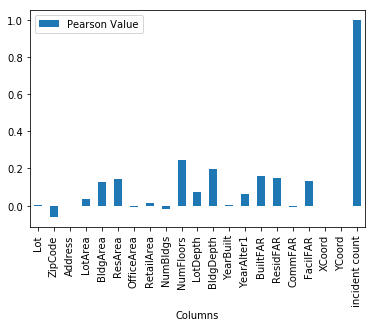

In [13]:
pearsonvalsdf.plot(kind='bar')

In [14]:
#Ignoring the 1 pearson value coming from incident account as it isn't suprisng that incident count correlates with inccident count, we find that all of the values do not have a very strong correlation with the amount of incidents with many
#not really being correlated
pearsonvalsdf

,Pearson Value
Columns,
Lot,0.000331
ZipCode,-0.063169
Address,0.000000
LotArea,0.034397
BldgArea,0.125485
ResArea,0.141368
OfficeArea,-0.005495
RetailArea,0.014412
NumBldgs,-0.017703


In [15]:
stats.pearsonr(df_merged['NumFloors'],df_merged['incident count'])
#Coincidently however, it seems that the number of floors is the strongest correlated, with a very low R value helping to give some confidence in the pearson value.
#The shape of the data suggests one very large peak once a building goes over 5 floors, followed by small peaks at each set of five floors after this.
#This could make sense if this was the height at which a new boiler or stronger plumbing would need to be installed specifically for the upper floors, the building owner may not be willing to pay for the expense of catering for floor five and up if there is only floor five.
#Likely it becomes easier to justify for buildings with a number of floors between these values, explaining the drop in complaints between.

(0.24294872818637264, 1.5021118982844637e-231)

In [16]:
#I would therefore say that the number of floors has the most obvious relation to the number of complaints, when looking at heating/hot water.
#Finally exporting the combined dataframe and the pearson values to be used in the next question.
df_merged.to_pickle('./df_merged.pkl')
client_cred.upload_file('./df_merged.pkl',bucket,'df_merged_cos.pkl')
pearsonvalsdf.to_pickle('./df_pearson.pkl')
client_cred.upload_file('./df_pearson.pkl',bucket,'df_pearson_cos.pkl')